In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import datetime
from bson import ObjectId
from pymongo import MongoClient

In [6]:
client = MongoClient('127.0.0.1', 27017)
db = client.moniter_crowdfunding
s_project = db.sucess_projects
project = db.projects
f_project = db.failure_projects

# 一、处理众筹成功项目

将累计动态数据转换为间隔时间段数据

In [3]:
def increment(x):
    return [(x[i] - x[i-1]) if i >= 1 else x[0] for i in range(len(x))]

- 项目描述性信息

In [4]:
def description(item):
    start_time = item['状态变换时间1-2']
    end_time = item['状态变换时间2-3']

    print(f"项目编号: {item['_id']}\n项目名称: {item['项目名称']}\n所属类别: {item['所属类别']}\n公司名称: {item['公司名称']}")
    print(f"\n众筹期限: {item['众筹期限']}\n项目状态: {item['状态']}")
    print()
    print("发起人页面:", f"http://z.jd.com/project/details/{item['_id']}.html") 
    print("项目页面:", f"http://z.jd.com{item['发起人链接']}")
    print()
    print('预热中:', item['状态变换时间0-1'].strftime('%Y年%m月%d日 %H:%M:%S'), sep='\t') 
    print('预热中->众筹中:', start_time.strftime('%Y年%m月%d日 %H:%M:%S'), sep='\t')
    print('众筹中->众筹成功:', end_time.strftime('%Y年%m月%d日 %H:%M:%S'), sep='\t')
    print('众筹中->项目成功:', item['状态变换时间3-4'].strftime('%Y年%m月%d日 %H:%M:%S'), sep='\t')

- 按照项目更新时间将项目动态信息转换为`pd.DataFrame()`

In [5]:
def to_df(item):
    dyn_info = item['项目动态信息']
    t_fund = item['目标金额']
    start_t = item['状态变换时间1-2']  # 众筹开始时间
    end_t = item['状态变换时间2-3']  # 众筹成功时间
    # 更加网所示的更新时间去除重复
    a1 = dyn_info[0]
    records = {'更新时间':[], '支持者数':[], '关注数':[], '点赞数':[], '完成百分比':[], '筹集金额':[]}
    for i, a2 in enumerate(dyn_info):
        if a2["更新时间"] != a1['更新时间']:
            records['更新时间'].append(a2['更新时间'])
            records['支持者数'].append(a2['支持者数'])
            records['关注数'].append(a2['关注数'])
            records['完成百分比'].append(a2['完成百分比'])
            records['筹集金额'].append(a2['筹集金额'])
            records['点赞数'].append(a2['点赞数'])
            a1 = a2
    # 绘图
    col_names = ['关注数', '支持者数', '点赞数', '完成百分比', '筹集金额']
    df = pd.DataFrame(records, index=records['更新时间'], columns=col_names)
    return df

- 转换为每天的增长数

In [6]:
def transfer_to_day(df):
    new_index = []
    for i, index in enumerate(df.index):
        if i == 0:
            a = df.index[i]
        else:
            b = df.index[i]
            a = df.index[i - 1]
            if (b.year, b.month, b.day) != (a.year, a.month, a.day):
                new_index.append(i-1)
    
    return df.iloc[new_index]

- 判断是否有邻居效应
> - 利用Bass模型与线性模型分别拟合：比较两种模型拟合的$r^2$
> - 如果有邻居影响，则进一步分析潜在影响网络的结构

In [10]:
proj = s_project.find_one()

In [11]:
proj.keys()

dict_keys(['_id', '各档动态信息', '众筹期限', '公司地址', '项目动态信息', '状态变换时间1-2', '各档基础信息', '爬取次数', '项目名称', '所属类别', '状态', '公司电话', '状态变换时间0-1', '目标金额', '发起人链接', '公司工作时间', '公司名称', '发起人名称', '评论', '状态变换时间2-3', '状态变换时间3-4'])

In [20]:
proj['评论']['评论详细']

{'1938346': {'topicId': 1938346,
  'key': '1000',
  'systemId': '100010',
  'pin': '_1cf1413ff9c6aa23de06f3be6e234929881c359206d041af489a82d99c7c3efb',
  'day': 157,
  'hour': 3771,
  'min': 226277,
  'replys': 1,
  'topicContent': '鞋子收到了，不错的做工，设计风格可以。还会出新款吗？怎么继续关注到你们呢？',
  'createTime': '2018-07-05 11:22:42',
  'updateTime': '2018-07-05 11:27:30',
  'status': 0,
  'indexStatus': 0,
  'topicType': 0,
  'topicSort': 0,
  'nicknameShow': 'jd_6b1388',
  'yunSmaImageUrl': '//storage.360buyimg.com/i.imageUpload/6a645f3662313338386332346437633931353236303931323135303039_mid.jpg',
  'serviceType': 1,
  'topicCount': 0,
  'likeCount': 0,
  'istread': 2,
  'islike': 2,
  'levelId': 0,
  'discussionPageVo': {'list': [{'discussionId': 2113684,
     'pin': '_28d2e66fbf9d38d656e3849ada83ba1fc23e93e87586bc24a95f34fdb48a3c36',
     'topicId': 1938346,
     'parentId': 0,
     'content': '谢谢您的认可和支持，LOKY专注原创设计，欢迎添加微信 xhtf28  备注鞋子，入群交流，继续关注我们',
     'replys': 0,
     'likeCount': 0,
     'status': 0,
  

#### 1. 获取每天各个时间段内关注数、支持者数、点赞数、完成百分比和筹集金额

In [26]:
def recursive_print(item, lev):
    if isinstance(item, dict):
        for i, x in enumerate(item, start=1):
            print('    '*lev, x)
            recursive_print(item[x], lev=lev+1)
    else:
        return

In [27]:
recursive_print(item, lev=0)

 _id
 状态变换时间0-1
 状态
 项目动态信息
 各档动态信息
 爬取次数
 众筹期限
 公司名称
 公司地址
 公司工作时间
 公司电话
 发起人名称
 发起人链接
 各档基础信息
     4
         redound_info
         deliver_info
         sup_price
         lim_num
     2
         redound_info
         deliver_info
         sup_price
         lim_num
     3
         redound_info
         deliver_info
         sup_price
         lim_num
     0
         redound_info
         deliver_info
         sup_price
         lim_num
     1
         redound_info
         deliver_info
         sup_price
         lim_num
     5
         redound_info
         deliver_info
         sup_price
         lim_num
     6
         redound_info
         deliver_info
         sup_price
         lim_num
 所属类别
 目标金额
 项目名称
 状态变换时间1-2
 评论
     爬取时间
     总页数
     总评论数
     评论详细
         1919544
             topicId
             key
             systemId
             pin
             day
             hour
             min
             replys
             topicContent
             createTime
       

In [9]:
item = s_project.find_one({"_id":'100051'})

In [16]:
for i, x in enumerate(item.keys(), start=1):
    print(i, x)
    try:
        for i in x.keys()

1 _id
2 状态变换时间0-1
3 状态
4 项目动态信息
5 各档动态信息
6 爬取次数
7 众筹期限
8 公司名称
9 公司地址
10 公司工作时间
11 公司电话
12 发起人名称
13 发起人链接
14 各档基础信息
15 所属类别
16 目标金额
17 项目名称
18 状态变换时间1-2
19 评论
20 状态变换时间2-3
21 状态变换时间3-4


In [12]:
item['项目动态信息'][0].keys()

dict_keys(['更新时间', '关注数', '支持者数', '筹集金额', '创建时间', '点赞数', '爬取时间', '完成百分比'])

In [14]:
item['评论'].keys(), item['评论']['评论详细'].keys()

(dict_keys(['爬取时间', '总页数', '总评论数', '评论详细']),
 dict_keys(['1919544', '1879513', '1877336', '1877117', '1877022', '1876920', '1876826', '1876723', '1876573', '1876529', '1876404', '1876382', '1876355', '1876329', '1876327', '1876322', '1876313', '1876231', '1876224', '1876004', '1874648']))

In [28]:
t_df = to_df(item)

In [31]:
t_df

,关注数,支持者数,点赞数,完成百分比,筹集金额
2018-04-28 11:30:27,9,0,6,0.0,0
2018-04-28 13:23:59,10,0,6,0.0,0
2018-04-28 17:54:30,11,0,7,0.0,0
2018-04-28 20:19:48,12,0,8,0.0,0
2018-04-28 22:35:52,13,0,9,0.0,0
2018-04-29 01:36:17,15,0,9,0.0,0
2018-04-29 13:44:59,15,0,10,0.0,0
2018-04-29 20:19:31,17,0,10,0.0,0
2018-04-30 09:18:24,21,0,11,0.0,0
2018-04-30 11:56:26,27,0,12,0.0,0


创建时间
```python
d = datetime.datetime(year=2018, month=12, day=23, hour=15, minute=11, second=11)
d.hour, d.minute, d.second, d.weekday()
```

In [34]:
d = datetime.datetime(year=2018, month=12, day=23, hour=15, minute=11, second=11)
d.hour, d.minute, d.second, d.weekday()

(15, 11, 11, 6)

In [39]:
t_df.iloc[1].name.weekday()

5

In [30]:
t_df.index.hour

Int64Index([11, 13, 17, 20, 22,  1, 13, 20,  9, 11, 12, 15,  1, 11, 12, 14, 17,
            20, 21,  5,  7,  9, 11, 13, 15, 17, 21,  0,  9, 12, 14, 15, 16, 18,
            23,  1,  3, 10, 13, 17, 18, 20,  0,  3,  9, 14, 21,  1, 15, 21, 15,
            16,  1,  9, 15, 18, 22,  0, 20, 12, 23, 16, 14, 17, 21, 15, 16, 22,
             0, 21,  8, 16, 19, 14, 10, 11, 23],
           dtype='int64')

In [32]:
list(zip(t_df.index.weekday, t_df.index.hour))

[(5, 11),
 (5, 13),
 (5, 17),
 (5, 20),
 (5, 22),
 (6, 1),
 (6, 13),
 (6, 20),
 (0, 9),
 (0, 11),
 (0, 12),
 (0, 15),
 (1, 1),
 (1, 11),
 (1, 12),
 (1, 14),
 (1, 17),
 (1, 20),
 (1, 21),
 (2, 5),
 (2, 7),
 (2, 9),
 (2, 11),
 (2, 13),
 (2, 15),
 (2, 17),
 (2, 21),
 (3, 0),
 (3, 9),
 (3, 12),
 (3, 14),
 (3, 15),
 (3, 16),
 (3, 18),
 (3, 23),
 (4, 1),
 (4, 3),
 (4, 10),
 (4, 13),
 (4, 17),
 (4, 18),
 (4, 20),
 (5, 0),
 (5, 3),
 (5, 9),
 (5, 14),
 (5, 21),
 (6, 1),
 (6, 15),
 (6, 21),
 (0, 15),
 (0, 16),
 (1, 1),
 (1, 9),
 (2, 15),
 (3, 18),
 (3, 22),
 (4, 0),
 (4, 20),
 (1, 12),
 (2, 23),
 (4, 16),
 (0, 14),
 (0, 17),
 (0, 21),
 (2, 15),
 (3, 16),
 (0, 22),
 (1, 0),
 (2, 21),
 (6, 8),
 (1, 16),
 (2, 19),
 (5, 14),
 (6, 10),
 (1, 11),
 (3, 23)]

In [ ]:
def getDayAdoptRange(df):
    '''
    (weekday, time_range)
    '''
    new_idx = []
    month_day = set(zip(df.index.month, df.index.day))
    for i in df.index.hour:
        if i.hour <= 6:
            
        elif i.hour <= 12:
            
        elif i.hour <= 18:
        
        else:
            
    

#### 2. 获取由**众筹开始时间**到**完成百分比第1次大于100**范围内的数据

In [44]:
def getTimeRange(df, start_t):
    x = df[df.index >= start_t]  # 开始众筹至观测结束
    y = x[x.完成百分比.values >= 100]  # 第一次达到众筹金额100%至观测结束
    d = x[:y.index[1]]  # 开始众筹至第一次达到众筹金额100%
    return d

获取所有**项目成功项目**的**众筹开始时间**到**完成百分比第1次大于100**的时间间隔

>其中涉及到pandas时间间隔转为秒，有两个关键的函数，首先通过`.to_pytimedelta()`将`pd.Timedelta()`转换为`datetime.datetime()`，然后利用`.total_seconds()`将`datetime.datetime()`转换为时间秒。示例：
```python
>>> pd.Timestamp("2012-12-21") - pd.Timestamp("2012-12-1")
Timedelta('20 days 00:00:00')
>>> pd.Timedelta('5:00:00').to_pytimedelta().total_seconds()
18000.0
>>> datetime.timedelta(days=1, hours=1, minutes=1).total_seconds()
90060.0
```

In [45]:
def getStatus(projs):  # 获取
    intv_dict, relative_intv_dict = [], []
    for i, item in enumerate(projs):
        try:
            start_t = item['状态变换时间1-2']  # 众筹开始时间
            end_t = item['状态变换时间2-3']  # 众筹成功时间
            df = to_df(item)
            t_df = getTimeRange(df, start_t)  # 开始众筹至第一次达到众筹金额100%
            time_interval = (t_df.index[-1] - t_df.index[0]).to_pytimedelta().total_seconds()  # 总时间，转化为浮点数(秒)
            tot_inteval = (end_t - start_t).total_seconds()  # 计划总时间
            intv_dict.append((item['_id'], time_interval))
            relative_intv_dict.append((item['_id'], time_interval / tot_inteval))
        except IndexError as e:
            print(i, item['_id'], e)
        except KeyError as k:
            print(i, item['_id'], k)
            
    df = pd.DataFrame({'绝对时间跨度': [x[1] for x in intv_dict], 
                       '相对时间跨度': [x[1] for x in relative_intv_dict]}, 
                       index = pd.Index([x[0] for x in intv_dict]))
    return df

In [46]:
projs = s_project.find({"状态": '项目成功'})
df1 = getStatus(projs)

14 100128 index 1 is out of bounds for axis 0 with size 0
30 100214 index 1 is out of bounds for axis 0 with size 1
34 100224 index 1 is out of bounds for axis 0 with size 0
64 100361 index 1 is out of bounds for axis 0 with size 1
68 100375 index 1 is out of bounds for axis 0 with size 0
83 100461 index 1 is out of bounds for axis 0 with size 1
96 100551 index 1 is out of bounds for axis 0 with size 1
116 100684 index 1 is out of bounds for axis 0 with size 1
124 100702 index 1 is out of bounds for axis 0 with size 0
180 100981 index 1 is out of bounds for axis 0 with size 1
222 101150 index 1 is out of bounds for axis 0 with size 0
330 101685 index 1 is out of bounds for axis 0 with size 0
336 101724 index 1 is out of bounds for axis 0 with size 0
350 101812 index 1 is out of bounds for axis 0 with size 1
360 101857 index 1 is out of bounds for axis 0 with size 1
371 101886 index 1 is out of bounds for axis 0 with size 0
379 101964 index 1 is out of bounds for axis 0 with size 1
390 

In [47]:
df1.head()

,绝对时间跨度,相对时间跨度
100010,3776038.0,0.962224
100031,483075.0,0.184856
100034,33800.0,0.008661
100040,1561563.0,0.404159
100049,20757.0,0.007985


- 累积分布

absolute status: 618039.2000 pass 0.5 density
relative status: 0.1987 pass 0.5 density


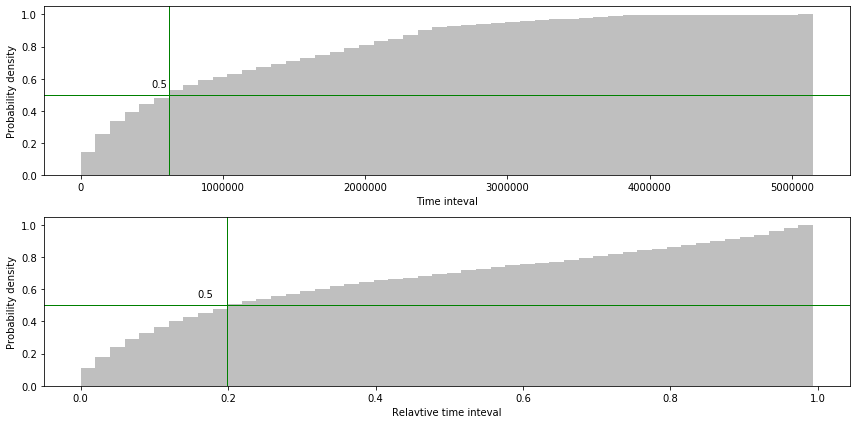

In [61]:
num_bins = 50
fig = plt.figure(figsize=(12, 6))
title = ['absolute status', 'relative status']
xLabels = ['Time inteval', 'Relavtive time inteval']
dataset = [df1['绝对时间跨度'].values, df1['相对时间跨度'].values]

num = 0.5
for i, x in enumerate(dataset):
    ax =fig.add_subplot(2, 1, i+1)
    n, bins, patches = ax.hist(x, num_bins, color='grey', alpha=0.5, density=1, cumulative=True)
    idx = np.argwhere(n == n[n > num][0])[0][0]
    print(f"{title[i]}: {bins[idx]:.4f} pass {num} density")
    ax.set_xlabel(xLabels[i])
    ax.set_ylabel('Probability density')
    ax.axhline(num, color='green', linestyle='-', linewidth=1)
    ax.axvline(bins[idx], color='green', linestyle='-', linewidth=1)
    ax.text(bins[idx]*0.8, num + 0.05, f"{num}", color='k')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

- 概率密度分布

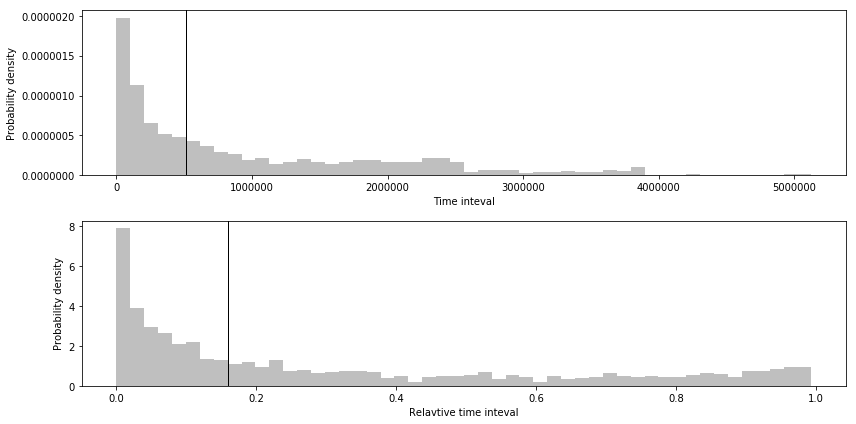

In [12]:
num_bins = 50
fig = plt.figure(figsize=(12, 6))
title = ['absolute status', 'relative status']
xLabels = ['Time inteval', 'Relavtive time inteval']
for i, x in enumerate(dataset):
    ax =fig.add_subplot(2, 1, i+1)
    n, bins, patches = ax.hist(x, num_bins, color='grey', alpha=0.5, density=True, stacked=True)
    accum_n = np.add.accumulate(n) / np.sum(n)
    idx = np.argwhere(accum_n >= num)[0][0]
    ax.axvline(bins[idx], color='k', linestyle='-', linewidth=1)
    ax.set_xlabel(xLabels[i])
    ax.set_ylabel('Probability density')
    #ax.axvline(bins[idx], color='red', linestyle='-', linewidth=2)
    #ax.text(bins[idx]*0.8, num + 0.05, f"{num}")

fig.tight_layout()
plt.show()

> 结论：
- （1）50%的众筹成功项目只用了期望时间的19.87%达成“众筹成功”；
- （2）40%的众筹成功项目只用了期望时间的11.93%达成“众筹成功”；
- （3）30%的众筹成功项目只用了期望时间的7.95%达成“众筹成功”；
- （4）20%的众筹成功项目只用了期望时间的3.98%达成“众筹成功”；
- （5）10%的众筹成功项目只用了期望时间的0.01%达成“众筹成功”；

### 探索性数据分析

In [62]:
oval_columns = ['状态', '众筹期限', '公司名称', '公司地址', '公司工作时间', '公司电话', '发起人名称', 
                '发起人链接', '所属类别', '目标金额', '项目名称', 
                '状态变换时间0-1', '状态变换时间1-2', '状态变换时间2-3', '状态变换时间3-4']

dyn_columns = ['筹集金额', '关注数', '支持者数', '点赞数', '完成百分比']
sts_columns = ['评论数量', '档位数量']

将所有项目的信息转换为`pd.DataFrame`

In [63]:
def proj_info(projs, oval_columns=oval_columns, sts_columns=sts_columns, dyn_columns=dyn_columns):
    col_names = oval_columns + sts_columns + dyn_columns
    cf_dict = {x:[] for x in col_names}
    idx = []
    for item in projs:
        idx.append(item['_id'])
        for c in oval_columns:
            try:
                cf_dict[c].append(item[c])
            except Exception as e:
                print(item['_id'], e)
                cf_dict[c].append(None)
        try:
            dyn_info = item['项目动态信息'][-1]
            for c in dyn_columns:
                try:
                    cf_dict[c].append(dyn_info[c])
                except Exception as e:
                    print(item['_id'], e)
                    cf_dict[c].append(None)
        except Exception as e:
            print(item['_id'], e)

        try:
            cf_dict['评论数量'].append(item['评论']['总评论数'])
        except Exception as e:
            cf_dict['评论数量'].append(None)
            
        try:
            cf_dict['档位数量'].append(len(item['各档基础信息']))
        except Exception as e:
            cf_dict['档位数量'].append(None)

    df = pd.DataFrame(cf_dict, index=idx, columns=col_names)
    return df

In [64]:
projs = s_project.find({'状态':'项目成功'})

In [65]:
df = proj_info(projs)

99138 '状态变换时间1-2'


In [66]:
df.count()

状态           2987
众筹期限         2987
公司名称         2984
公司地址         2984
公司工作时间       2984
公司电话         2984
发起人名称        2987
发起人链接        2987
所属类别         2987
目标金额         2987
项目名称         2987
状态变换时间0-1    2987
状态变换时间1-2    2986
状态变换时间2-3    2987
状态变换时间3-4    2987
评论数量         2987
档位数量         2987
筹集金额         2987
关注数          2987
支持者数         2987
点赞数          2987
完成百分比        2987
dtype: int64

- 和扩散时间跨度合并

In [70]:
dtf = pd.concat([df, df1], axis=1, join_axes=[df.index], sort=True)

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  """Entry point for launching an IPython kernel.


In [73]:
col = ['状态', '众筹期限', '所属类别', '目标金额', '项目名称', '筹集金额', 
       '关注数', '支持者数', '点赞数', '完成百分比', '评论数量', '档位数量', 
      '绝对时间跨度', '相对时间跨度']

In [74]:
dtf[col].head()

,状态,众筹期限,所属类别,目标金额,项目名称,筹集金额,关注数,支持者数,点赞数,完成百分比,评论数量,档位数量,绝对时间跨度,相对时间跨度
100010,项目成功,45,原创设计,50000,一双街头潮流与运动的跨界鞋,50971,172,137,19,102.0,49,3,3776038.0,0.962224
100031,项目成功,30,原创设计,100000,lorde时光隧道宠物笼,254904,597,496,557,255.0,22,3,483075.0,0.184856
100034,项目成功,45,原创设计,30000,华夏匠心·斗茶神器古法建盏,37109,67,303,5,124.0,4,8,33800.0,0.008661
100040,项目成功,45,原创设计,100000,iBranco上上筷礼盒,102824,160,233,38,103.0,38,3,1561563.0,0.404159
100049,项目成功,30,原创设计,10000,百工潮牌---能量玛瑙手串,30122,280,220,10,301.0,60,9,20757.0,0.007985


- 相关系数

In [107]:
col_name = ['关注数', '支持者数', '评论数量', '档位数量', '绝对时间跨度', '相对时间跨度', '完成百分比']
dtf[col_name].corr()

,关注数,支持者数,评论数量,档位数量,绝对时间跨度,相对时间跨度,完成百分比
关注数,1.000000,0.352332,0.374857,0.151010,-0.170109,-0.178073,0.021211
支持者数,0.352332,1.000000,0.515751,0.125844,-0.154313,-0.179207,0.052356
评论数量,0.374857,0.515751,1.000000,0.134168,-0.166271,-0.180156,0.031675
档位数量,0.151010,0.125844,0.134168,1.000000,-0.182279,-0.189832,-0.035220
绝对时间跨度,-0.170109,-0.154313,-0.166271,-0.182279,1.000000,0.937107,-0.081760
相对时间跨度,-0.178073,-0.179207,-0.180156,-0.189832,0.937107,1.000000,-0.086578
完成百分比,0.021211,0.052356,0.031675,-0.035220,-0.081760,-0.086578,1.000000


In [76]:
dtf.describe()

,众筹期限,目标金额,评论数量,档位数量,筹集金额,关注数,支持者数,点赞数,完成百分比,绝对时间跨度,相对时间跨度
count,2987.000000,2.987000e+03,2987.000000,2987.000000,2.987000e+03,2987.000000,2987.000000,2987.000000,2987.000000,2.822000e+03,2822.000000
mean,35.319049,7.574120e+04,71.044861,2.982591,3.262415e+05,641.492802,731.956478,463.900904,778.937730,1.038014e+06,0.340193
std,8.801505,1.078760e+05,127.834934,3.190486,1.538044e+06,1249.495158,2151.419195,1314.244948,7455.397068,1.012142e+06,0.318206
min,10.000000,5.000000e+00,0.000000,0.000000,1.626000e+03,0.000000,1.000000,0.000000,27.000000,2.420000e+02,0.000094
25%,30.000000,2.000000e+04,15.000000,0.000000,5.022100e+04,80.000000,104.000000,11.000000,110.000000,1.962775e+05,0.063985
50%,30.000000,5.000000e+04,37.000000,3.000000,9.387500e+04,216.000000,228.000000,33.000000,159.000000,6.514795e+05,0.212910
75%,45.000000,1.000000e+05,80.500000,5.000000,2.011630e+05,1065.000000,573.500000,557.500000,286.000000,1.768230e+06,0.601721
max,60.000000,3.000000e+06,1893.000000,24.000000,4.018386e+07,31909.000000,55230.000000,28972.000000,231800.000000,5.148552e+06,0.993284


In [23]:
961277/3600/24

11.125891203703704

- 各类别信息

In [101]:
cat_dict = {name: group for name, group in dtf.groupby('所属类别')}

In [106]:
for name, group in sorted(list(cat_dict.items()), 
                        key=lambda x: len(x[1]), 
                        reverse=1):
    print(name, len(group))

原创设计 436
食品 409
公益 405
文化传承 330
智能家居 190
数码周边 159
健康医疗 123
车品 119
健康生活 114
设计家居 100
可穿戴 93
品质家居 66
个人护理 62
时尚科技 57
专属定制 53
体育 45
手机周边 32
母婴 25
健身装备 23
其它 23
生活电器 23
情趣用品 18
图书 17
空气净化 14
游戏 10
手机 8
水健康 8
冰洗卫浴 5
旅游 4
检测设备 4
大家电 2
安防 2
手环 2
音乐 2
扶贫 1
活动 1
电脑 1
美妆 1


- 简单线性回归

In [81]:
import statsmodels.formula.api as smf

In [85]:
mod = smf.ols(formula='相对时间跨度~关注数+支持者数+评论数量-1', data=dtf)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                 相对时间跨度   R-squared (uncentered):                   0.080
Model:                            OLS   Adj. R-squared (uncentered):              0.079
Method:                 Least Squares   F-statistic:                              82.04
Date:                Tue, 10 Dec 2019   Prob (F-statistic):                    7.00e-51
Time:                        12:15:12   Log-Likelihood:                         -1730.0
No. Observations:                2822   AIC:                                      3466.
Df Residuals:                    2819   BIC:                                      3484.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [109]:
mod = smf.ols(formula='完成百分比~关注数+支持者数+评论数量-1', data=dtf)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                  完成百分比   R-squared (uncentered):                   0.009
Model:                            OLS   Adj. R-squared (uncentered):              0.008
Method:                 Least Squares   F-statistic:                              8.683
Date:                Tue, 10 Dec 2019   Prob (F-statistic):                    9.81e-06
Time:                        20:05:02   Log-Likelihood:                         -30875.
No. Observations:                2987   AIC:                                  6.176e+04
Df Residuals:                    2984   BIC:                                  6.177e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [110]:
res.params

关注数     0.136480
支持者数    0.167830
评论数量    1.805268
dtype: float64

- 项目金额完成百分比统计信息

In [28]:
percent = dtf[col]['完成百分比'].values

In [29]:
np.mean(percent),np.std(percent)

(816.6955655206776, 7118.188382168677)

In [30]:
np.max(percent), np.min(percent)

(231800.0, 27.0)

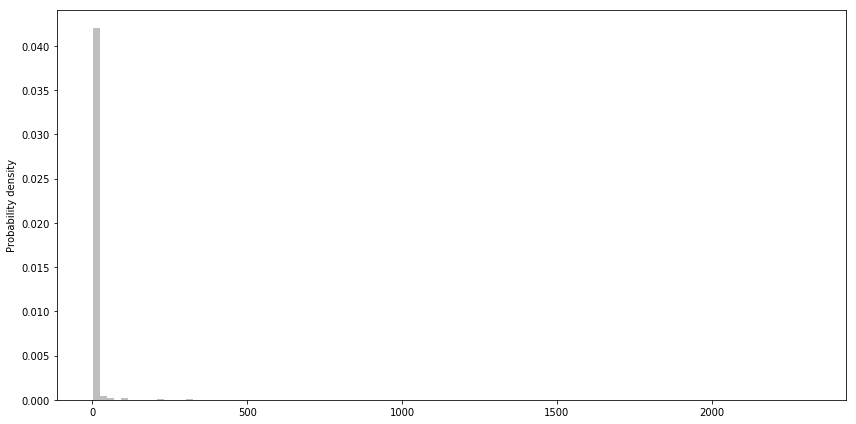

In [31]:
num_bins = 100
fig = plt.figure(figsize=(12, 6))
title = ['absolute status', 'relative status']
xLabels = ['Time inteval', 'Relavtive time inteval']

ax =fig.add_subplot(1, 1, 1)
n, bins, patches = ax.hist(percent/100, num_bins, color='grey', alpha=0.5, density=1)
ax.set_xlabel('')
ax.set_ylabel('Probability density')

fig.tight_layout()
plt.show()

- plotly绘图

In [111]:
import plotly as py
from plotly.graph_objs import Histogram, Scatter, Layout, Data, XAxis, Figure
import plotly.figure_factory as ff
py.offline.init_notebook_mode()

ModuleNotFoundError: No module named 'plotly'

In [3]:
data = [Histogram(x=percent/100, histnorm='probability')]
py.offline.iplot(data, filename='fifth_offline_chart.html')

NameError: name 'percent' is not defined

In [ ]:
x1, x2 = dataset

trace0 = Histogram(
    x = x1,
    name='',
    histnorm = 'probability',
    cumulative={"enabled":False},
    opacity = 0.75,
    xaxis="x1")

trace1 = Histogram(
    x=x2,
    name='',
    histnorm='probability',
    cumulative={"enabled":False},
    opacity=0.75,
    xaxis="x2")

data = [trace0, trace1]
layout = Layout(barmode='overlay', 
                title='众筹开始至成功的时间跨度',
                xaxis1={"domain": [0, 0.5], 
                        "title": "绝对跨度"}, 
                xaxis2={"domain": [0.5, 1], 
                        "title": "相对跨度"}
               )

fig = Figure(data=data, layout=layout)
py.offline.iplot(fig, filename='sixth_chart.html')